In [33]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = "300"

In [19]:
data = pd.read_csv('../adobe/sample.csv').drop('Unnamed: 0',axis=1)

In [20]:
data.info(null_counts=True)
df = data.set_index('uuid')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371486 entries, 0 to 1371485
Data columns (total 6 columns):
uuid                     1371486 non-null object
encodedTraits.type       1371486 non-null int64
encodedTraits.size       1371486 non-null int64
encodedTraits.indices    1371486 non-null object
encodedTraits.values     1371486 non-null object
from_file                1371486 non-null int64
dtypes: int64(3), object(3)
memory usage: 62.8+ MB


,uuid,encodedTraits.type,encodedTraits.size,encodedTraits.indices,encodedTraits.values,from_file
0,9ebc1bd3-9cae-5540-9b68-2173e151405a,0,5197,[800],[1.0],0
1,3267b648-f9ba-5252-ae8c-2e96d2efd802,0,5197,"[800, 2268, 4199, 4265, 4279, 4413, 4931]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0
2,eb786b48-dc5e-5c86-981d-01b5ac99831b,0,5197,"[51, 800, 4211, 4265, 4269, 4412, 4413, 5051, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0
3,f76fcdb1-a203-5d48-a96c-a10c88f4b07c,0,5197,[800],[1.0],0
4,017f25d1-fcac-5996-a564-bd208baa8281,0,5197,[800],[1.0],0


In [21]:
print("Number of Unique users in sample {}.".format(len(data.uuid.unique())))

Number of Unique users in sample 1371486.


In the sample,

There is about 1.4M distinct user taken from 10% random sample per file.

### I. Visualization with Sample

In [23]:
# convert to user-item pair
SAMPLE_SIZE = 10000
df_new = pd.melt(
    df.sample(SAMPLE_SIZE)['encodedTraits.indices'].apply(ast.literal_eval)
                                 .apply(pd.Series)
                                     .reset_index(),
    id_vars=['uuid'],
    value_name='encodedTraits.indices'

).dropna().drop('variable', axis=1)
df_new['encodedTraits.indices'] = df_new['encodedTraits.indices'].astype(int)

In [64]:
print("{} Unique Traits in 10000 Sample".format(len(df_new['encodedTraits.indices'].unique())))

3673 Unique Traits in 10000 Sample


Take 10000 users as a sample, it covers 3614 traits (about 70%).

1. Distribution of trait frequency per user is highly right-skewed. trait # 800 as the most frequent trait for users, and there is a large gap between the most popular trait and the rest (more than 50% difference). The median of the traits has about 0.13% user population in the sample.



2. [Long tail] 10% of the traits have 0.001% users have the attribute.



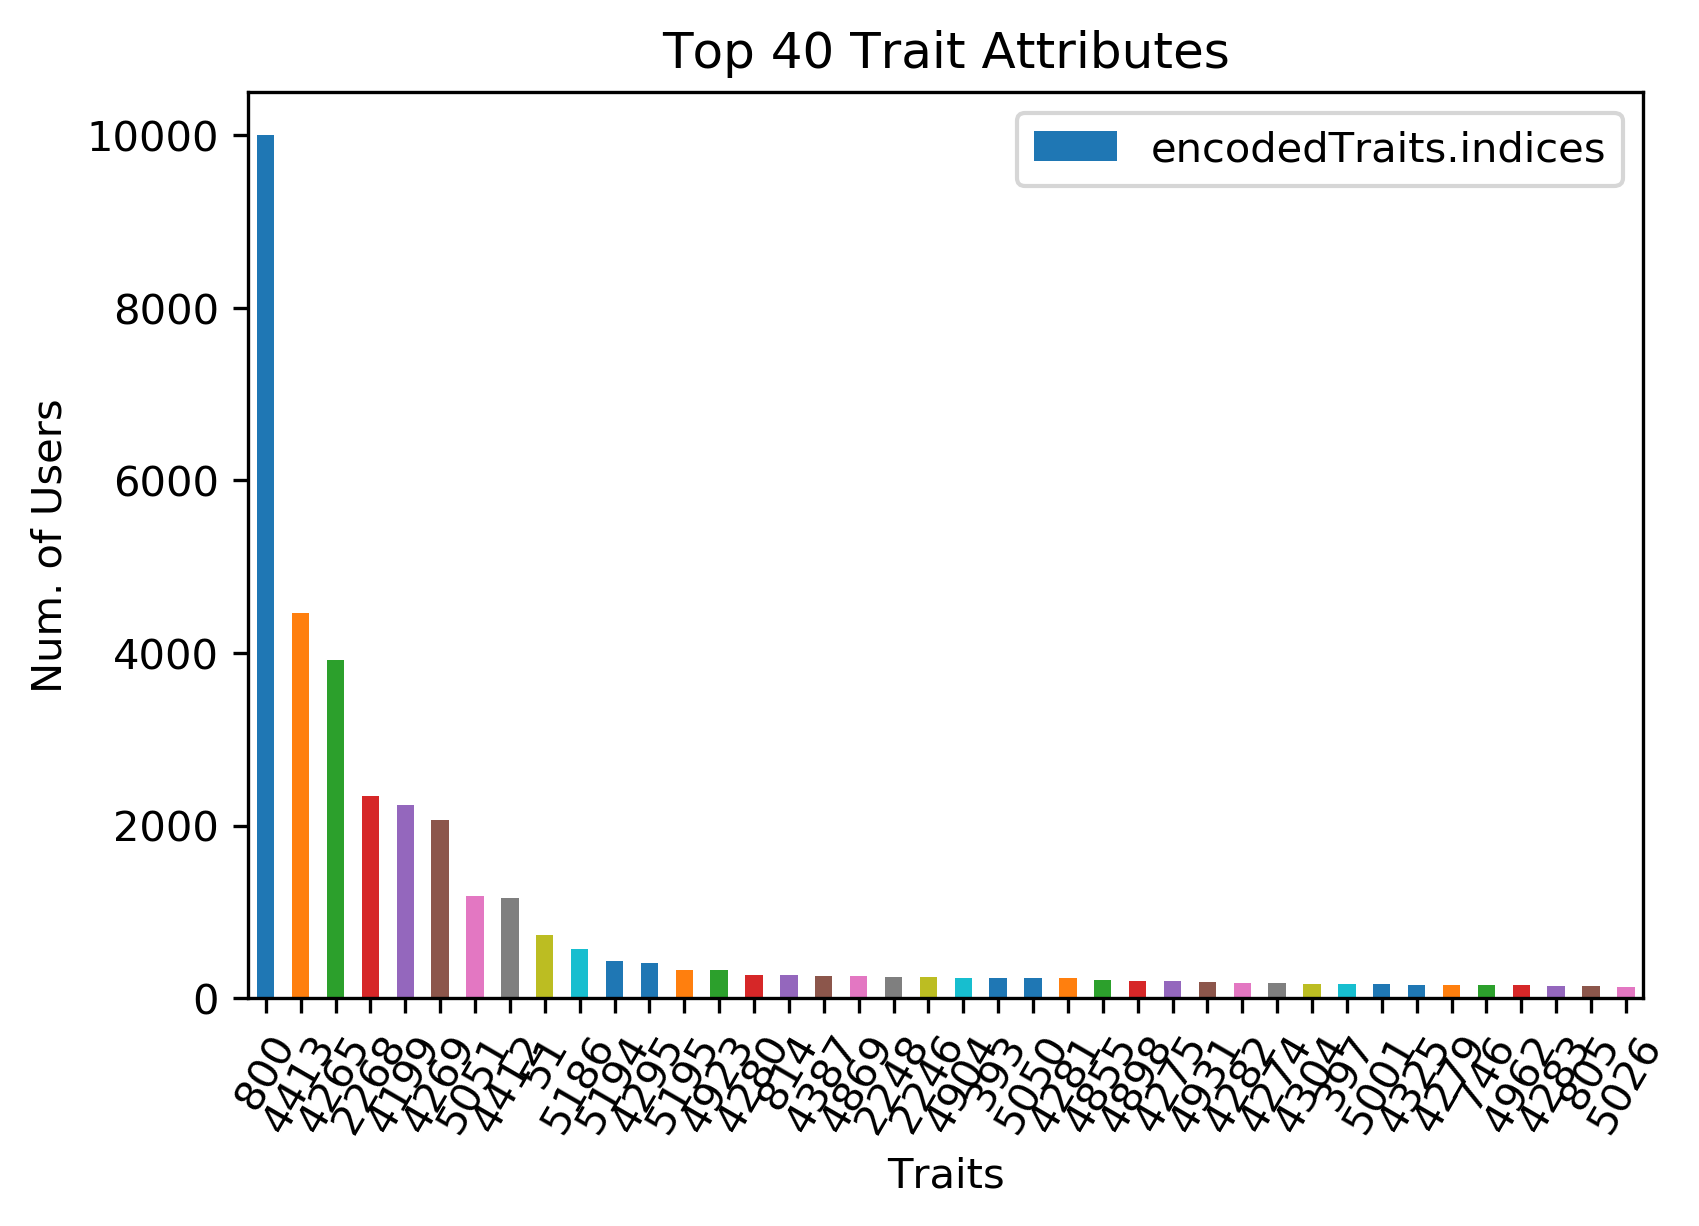

In [37]:
# ranked item occurance 
item_df = df_new['encodedTraits.indices'].value_counts().reset_index()
item_df[:40].plot.bar(x='index', y='encodedTraits.indices', rot=60)
plt.xlabel("Traits")
plt.ylabel("Num. of Users")
plt.title("Top 40 Trait Attributes")
plt.show()

In [31]:
item_df.describe(percentiles = np.arange(0.0,1.0,0.1))

,index,encodedTraits.indices
count,3673.000000,3673.000000
mean,2509.038660,27.864144
std,1443.417796,205.351929
min,3.000000,1.000000
0%,3.000000,1.000000
10%,549.200000,1.000000
20%,1028.400000,3.000000
30.0%,1576.600000,5.000000
40%,1950.800000,8.000000
50%,2385.000000,13.000000


### II. USER VS. ITEM FREQUENCE on Entire Dataset
From the user perspective, examine the 1.4M sample users:

1. The long tail effect is more obvious, as expected since we have a lot more users than traits, and the median number of trait a user has is 1. That is over 50% of users have only one trait.



2. A visualization of the users with most of the traits shows that there is no obvious gap in the top 40 users.



In [32]:
user_df = data['encodedTraits.indices'].apply(ast.literal_eval).apply(len)
user_df.reset_index()
user_df.describe(percentiles = np.arange(0.0,1.0,0.1))

count    1.371486e+06
mean     9.563853e+00
std      6.677275e+01
min      1.000000e+00
0%       1.000000e+00
10%      1.000000e+00
20%      1.000000e+00
30.0%    1.000000e+00
40%      1.000000e+00
50%      1.000000e+00
60.0%    5.000000e+00
70%      7.000000e+00
80%      7.000000e+00
90%      8.000000e+00
max      2.426000e+03
Name: encodedTraits.indices, dtype: float64

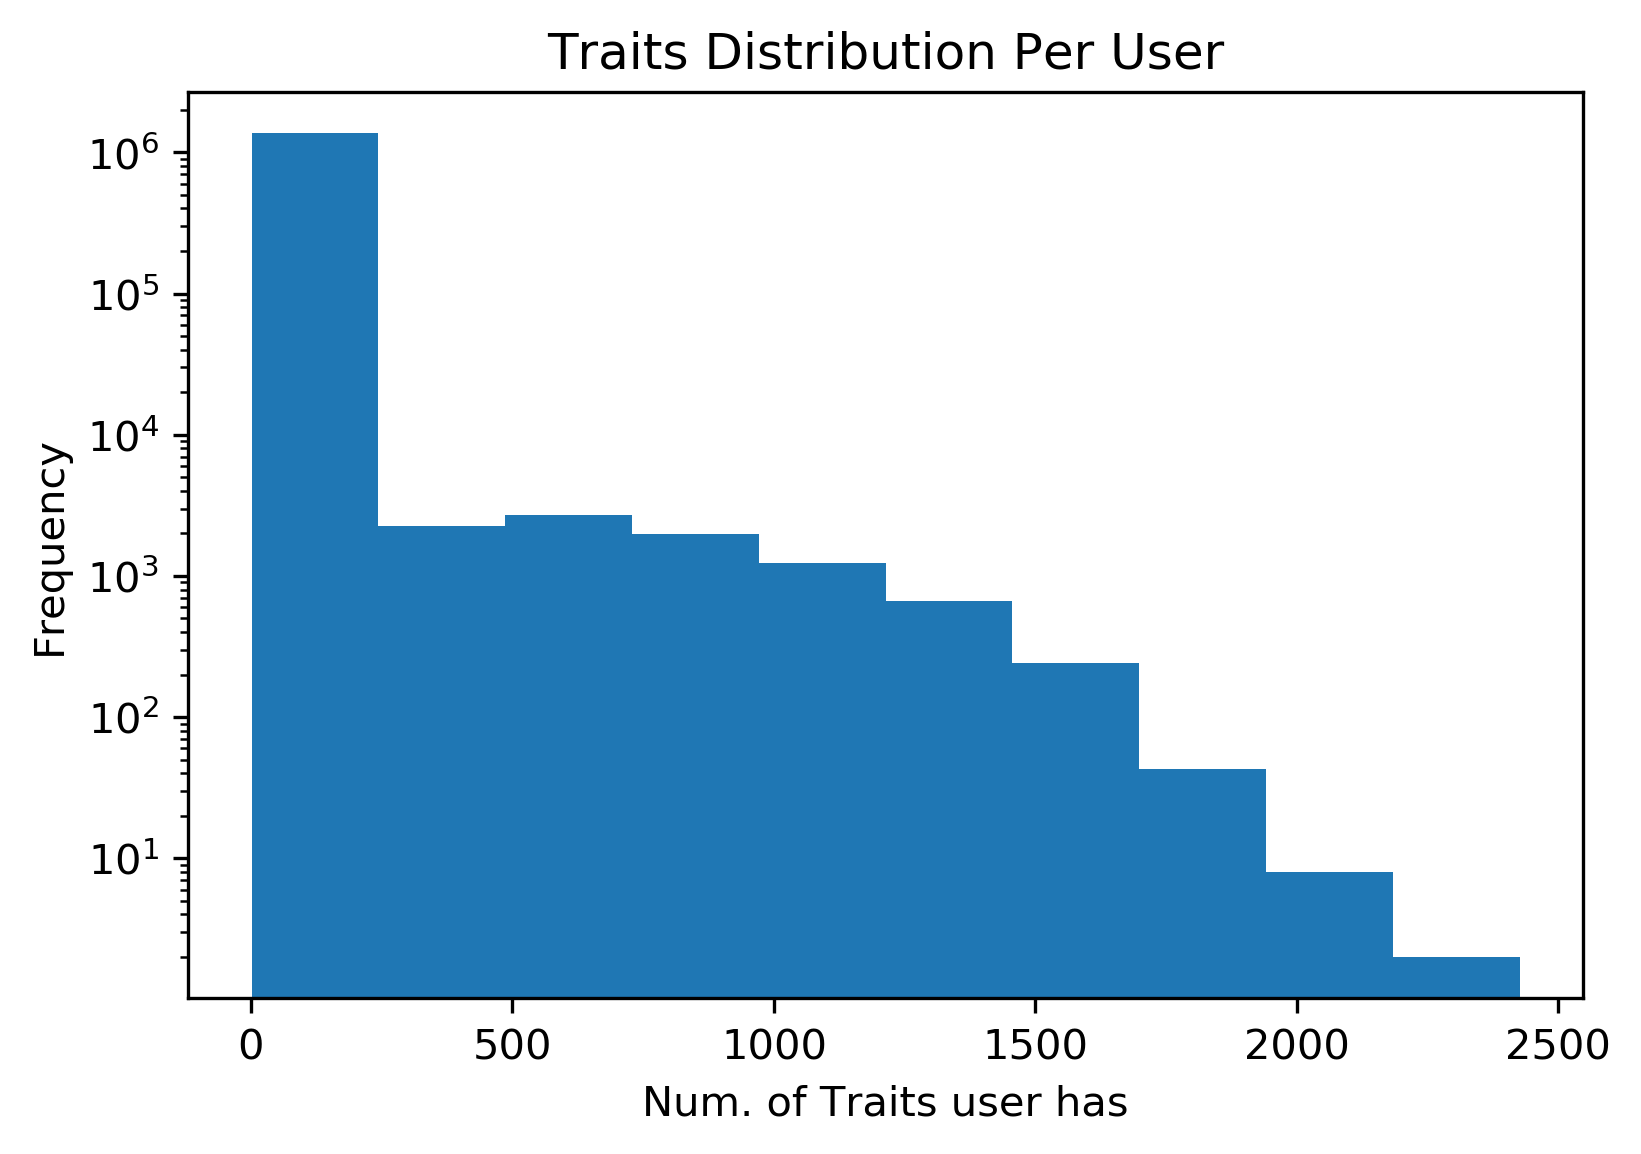

In [36]:
# ITEM FREQUENCE: num time the item occur per user
plt.hist(user_df)
plt.yscale("log")
plt.xlabel("Num. of Traits user has")
plt.ylabel("Frequency")
plt.title("Traits Distribution Per User")
plt.show()

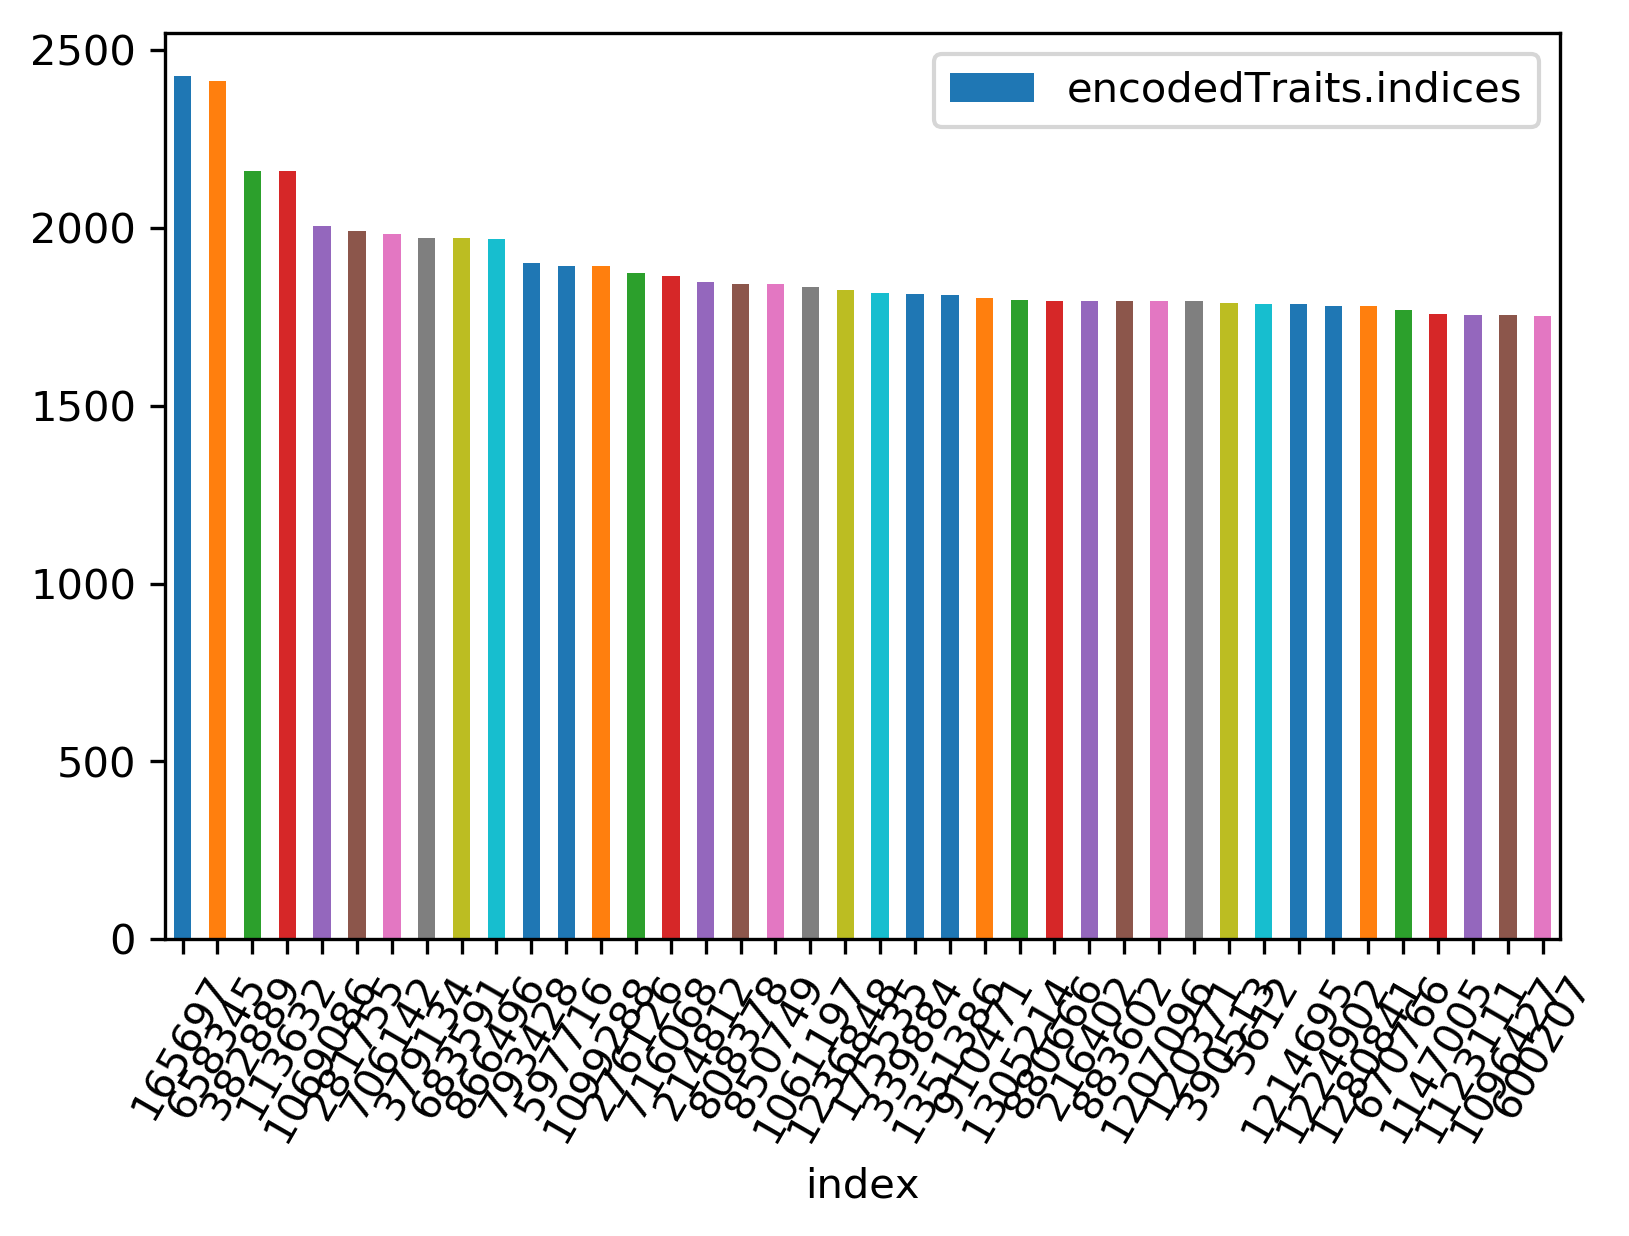

In [38]:
(user_df.sort_values(ascending = False)[:40]
     .reset_index()
         .plot.bar(x='index', y='encodedTraits.indices', rot=60))

### III. Check All Users with a Single Trait

In [62]:
data['num_trait']=user_df
temp = (data.loc[data.num_trait==1]['encodedTraits.indices'])
print("number of user with 1 trait {} -- {:.2f}% of the sample".format(len(temp),(len(temp)/len(data))*100))
print("The trait is {}".format(temp.unique()))

number of user with 1 trait 693790 -- 50.59% of the sample
The trait is ['[800]']
